# Imports

In [ ]:
import umap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.v2 as transforms
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
from torch.utils.data import Dataset
from tqdm import tqdm
import plotly.express as px

# Constants

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [74]:
IMAGE_SIZE = 32
NUM_CLASSES = 10
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

EMBEDDING_SIZE = 128
TEMPERATURE = 0.01

WARMUP_EPOCHS = 5
PRETRAINING_EPOCHS = 100
FINETUNING_EPOCHS = 50
FINETUNING_SUBSET_EPOCHS = 50
SUPERVISED_EPOCHS = 100
SUPERVISED_SUBSET_EPOCHS = 100

BATCH_SIZE = 256
INITIAL_LR = 1e-3
FINAL_LR = 3e-5
WEIGHT_DECAY_FINETUNING = 5e-3
WEIGHT_DECAY_SUPERVISED = 5e-2

SEED = 42

# Data augmentation

In [6]:
cifar10 = torchvision.datasets.CIFAR10(root="../datasets", train=True, download=True)
cifar10[0]

Files already downloaded and verified


(<PIL.Image.Image image mode=RGB size=32x32>, 6)

In [ ]:
encoder_train_transforms = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ToDtype(dtype=torch.float32, scale=True),
        torchvision.transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=IMAGE_SIZE),
        transforms.RandomApply(
            [
                transforms.ColorJitter(
                    brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2
                ),
            ],
            p=0.8,
        ),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=3),
        transforms.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
    ]
)

classifier_train_transforms = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ToDtype(dtype=torch.float32, scale=True),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=IMAGE_SIZE, scale=(0.2, 1.0)),
        transforms.RandomRotation(15),
        transforms.RandomApply(
            [
                transforms.ColorJitter(
                    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2
                ),
            ],
            p=0.8,
        ),
        transforms.RandomGrayscale(p=0.2),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    ]
)

eval_transforms = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ToDtype(dtype=torch.float32, scale=True),
        transforms.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
    ]
)

In [8]:
def denormalize(x):
    x = x * torch.tensor(CIFAR10_STD).view(3, 1, 1)
    x = x + torch.tensor(CIFAR10_MEAN).view(3, 1, 1)
    return x

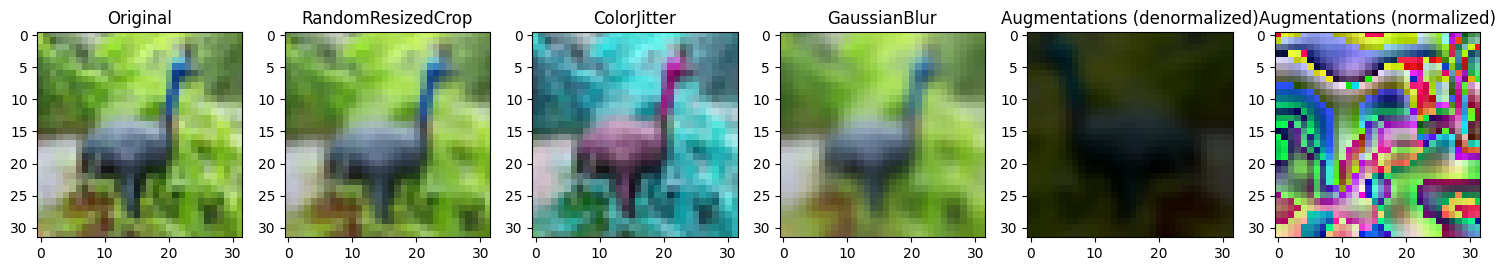

In [ ]:
img_pil, label = cifar10[6]
to_tensor = transforms.ToImage()
to_pil = transforms.ToPILImage()

fig, axs = plt.subplots(1, 6, figsize=(15, 5))

axs[0].imshow(img_pil)
axs[0].set_title("Original")

axs[1].imshow(to_pil(transforms.RandomResizedCrop(size=IMAGE_SIZE)(to_tensor(img_pil))))
axs[1].set_title("RandomResizedCrop")

axs[2].imshow(to_pil(transforms.ColorJitter(hue=0.5)(to_tensor(img_pil))))
axs[2].set_title("ColorJitter")

axs[3].imshow(to_pil(transforms.GaussianBlur(kernel_size=3)(to_tensor(img_pil))))
axs[3].set_title("GaussianBlur")

axs[4].imshow(to_pil(denormalize(encoder_train_transforms(to_tensor(img_pil)))))
axs[4].set_title("Augmentations (denormalized)")

axs[5].imshow(to_pil(encoder_train_transforms(to_tensor(img_pil))))
axs[5].set_title("Augmentations (normalized)")

plt.tight_layout()
plt.show()

# Contrastive dataset

In [10]:
class ContrastiveDataset(Dataset):
    def __init__(self, dataset, augmentations):
        self.dataset = dataset
        self.augmentations = augmentations

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        return self.augmentations(img), self.augmentations(img)

    def __len__(self):
        return len(self.dataset)

# Loss

In [11]:
class NTXent(nn.Module):
    def __init__(self, temperature):
        super().__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        assert batch_size == z_j.shape[0], "Batch sizes must match"

        z_i = F.normalize(z_i, dim=-1)
        z_j = F.normalize(z_j, dim=-1)

        z = torch.cat([z_i, z_j], dim=0)  # [2 * batch_size, embedding_size]

        similarity_matrix = (
            F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=-1)
            / self.temperature
        )  # [2 * batch_size, 2 * batch_size]

        sim_i_j = torch.diag(similarity_matrix, batch_size)  # [batch_size]
        sim_j_i = torch.diag(similarity_matrix, -batch_size)  # [batch_size]

        positive_samples = torch.cat([sim_i_j, sim_j_i], dim=0).unsqueeze(
            1
        )  # [2 * batch_size, 1]

        mask = torch.zeros(
            2 * batch_size,
            2 * batch_size,
            dtype=torch.bool,
            device=similarity_matrix.device,
        ).fill_diagonal_(True)
        
        indices = torch.arange(batch_size, device=similarity_matrix.device)
        mask[indices, indices + batch_size] = True
        mask[indices + batch_size, indices] = True

        negative_samples = similarity_matrix[~mask].view(
            2 * batch_size, -1
        )  # [2 * batch_size, 2*batch_size-2]
        
        logits = torch.cat(
            [positive_samples, negative_samples], dim=1
        )  # [2 * batch_size, 2*batch_size-1]
        
        labels = torch.zeros(2 * batch_size, dtype=torch.long, device=logits.device)
        
        loss = F.cross_entropy(logits, labels)
        return loss

# Encoder Model

In [12]:
class Encoder(nn.Module):
    def __init__(self, encoder: nn.Module, projection_size: int):
        super().__init__()

        assert hasattr(encoder, "fc"), "Base encoder must have a fc layer"

        self.encoder = encoder
        self.embedding_size = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()
        self.projection_head = nn.Sequential(
            nn.Linear(self.embedding_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, projection_size),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.projection_head(x)
        return x

In [13]:
def get_encoder(pretrained: bool, projection_head: bool = False):
    resnet = torchvision.models.resnet18(weights=None)
    # CIFAR10 modifications for resnet
    resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    resnet.maxpool = nn.Identity()
    
    encoder = Encoder(
        encoder=resnet,
        projection_size=EMBEDDING_SIZE,
    ).to(device)
    
    if pretrained:
        encoder.load_state_dict(
            torch.load(
                "/kaggle/input/simclr_cifar10/keras/default/1/cifar10_encoder.pth",
                weights_only=True,
            )
        )
        
    if not projection_head:
        encoder.projection_head = nn.Identity()
    
    return encoder

# Data Split

In [14]:
train_dataset, valid_dataset = torch.utils.data.random_split(
    torchvision.datasets.CIFAR10(root="../datasets", train=True, download=True),
    [45000, 5000],
    generator=torch.Generator().manual_seed(SEED),
)
test_dataset = torchvision.datasets.CIFAR10(
    root="../datasets", train=False, download=True
)

Files already downloaded and verified
Files already downloaded and verified


# Self-Supervised Pretraining

In [ ]:
train_contrastive_dataset = ContrastiveDataset(train_dataset, encoder_train_transforms)
valid_contrastive_dataset = ContrastiveDataset(valid_dataset, eval_transforms)
test_contrastive_dataset = ContrastiveDataset(test_dataset, eval_transforms)

train_loader = torch.utils.data.DataLoader(
    train_contrastive_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)
val_loader = torch.utils.data.DataLoader(
    valid_contrastive_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)
test_loader = torch.utils.data.DataLoader(
    test_contrastive_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

In [17]:
encoder = get_encoder(pretrained=False, projection_head=True)
optimizer = torch.optim.AdamW(encoder.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = NTXent(temperature=TEMPERATURE).to(device)
scaler = GradScaler(device=device)
scheduler = SequentialLR(
    optimizer,
    schedulers=[
        LinearLR(
            optimizer, start_factor=0.1, end_factor=1.0, total_iters=WARMUP_EPOCHS
        ),
        CosineAnnealingLR(
            optimizer, T_max=PRETRAINING_EPOCHS - WARMUP_EPOCHS, eta_min=FINAL_LR
        ),
    ],
    milestones=[WARMUP_EPOCHS],
)

In [ ]:
train_loss_hisotry = []
val_loss_history = []
best_val_loss = float("inf")

for epoch in range(PRETRAINING_EPOCHS):
    encoder.train()
    train_loss = 0.0
    num_batches = 0
    progress_bar = tqdm(
        train_loader, desc=f"Epoch {epoch + 1}/{PRETRAINING_EPOCHS} [Train]"
    )
    for imgs_i, imgs_j in progress_bar:
        imgs_i = imgs_i.to(device, non_blocking=True)
        imgs_j = imgs_j.to(device, non_blocking=True)

        optimizer.zero_grad()

        with autocast(device_type=device.type):
            combined = torch.cat([imgs_i, imgs_j], dim=0)
            embeddings = encoder(combined)
            z_i, z_j = torch.split(embeddings, combined.shape[0] // 2)
            loss = criterion(z_i, z_j)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        num_batches += 1
        progress_bar.set_postfix({"loss": loss.item()})

    epoch_avg_train_loss = train_loss / num_batches
    train_loss_hisotry.append(epoch_avg_train_loss)

    encoder.eval()
    epoch_val_loss_sum = 0.0
    num_batches = 0
    progress_bar = tqdm(
        val_loader, desc=f"Epoch {epoch + 1}/{PRETRAINING_EPOCHS} [Valid]"
    )
    for imgs_i, imgs_j in progress_bar:
        imgs_i = imgs_i.to(device, non_blocking=True)
        imgs_j = imgs_j.to(device, non_blocking=True)

        with torch.no_grad():
            with autocast(device_type=device.type):
                combined = torch.cat([imgs_i, imgs_j], dim=0)
                embeddings = encoder(combined)
                z_i, z_j = torch.split(embeddings, combined.shape[0] // 2)
                loss = criterion(z_i, z_j)

        epoch_val_loss_sum += loss.item()
        num_batches += 1
        progress_bar.set_postfix({"loss": loss.item()})

    epoch_avg_val_loss = epoch_val_loss_sum / num_batches
    val_loss_history.append(epoch_avg_val_loss)

    if epoch_avg_val_loss < best_val_loss:
        best_val_loss = epoch_avg_val_loss
        torch.save(encoder.state_dict(), "cifar10_encoder.pth")

    print(
        f"Epoch {epoch + 1}/{PRETRAINING_EPOCHS} - "
        f"Train Loss: {epoch_avg_train_loss:.4f}, "
        f"Validation Loss: {epoch_avg_val_loss:.4f}"
    )

    scheduler.step()

# Classifier Training Loop

In [ ]:
def train_supervised(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    epochs: int,
    warmup_epochs: int,
    final_lr: float,
    weight_decay: float,
    experiment_name: str,
    device=device,
):
    optimizer = torch.optim.AdamW(
        model.parameters(), weight_decay=weight_decay
    )
    criterion = nn.CrossEntropyLoss().to(device)
    scaler = GradScaler(device=device)
    scheduler = SequentialLR(
        optimizer,
        schedulers=[
            LinearLR(
                optimizer, start_factor=0.1, end_factor=1.0, total_iters=warmup_epochs
            ),
            CosineAnnealingLR(
                optimizer, T_max=epochs - warmup_epochs, eta_min=final_lr
            ),
        ],
        milestones=[warmup_epochs],
    )

    train_losses = []
    val_losses = []
    best_val_loss = float("inf")

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [Train]")

        for i, (imgs, labels) in enumerate(progress_bar):
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            with autocast(device_type=device.type):
                logits = model(imgs)
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

            _, predicted = torch.max(logits.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            progress_bar.set_postfix(
                {"loss": loss.item(), "acc": 100 * train_correct / train_total}
            )

        epoch_train_acc = 100 * train_correct / train_total
        epoch_avg_train_loss = train_loss / (i + 1)
        train_losses.append(epoch_avg_train_loss)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} [Valid]")

        with torch.no_grad():
            for i, (imgs, labels) in enumerate(progress_bar):
                imgs, labels = (
                    imgs.to(device, non_blocking=True),
                    labels.to(device, non_blocking=True),
                )

                with autocast(device_type=device.type):
                    logits = model(imgs)
                    loss = criterion(logits, labels)

                val_loss += loss.item()

                _, predicted = torch.max(logits.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                progress_bar.set_postfix(
                    {"loss": loss.item(), "acc": 100 * val_correct / val_total}
                )

        epoch_val_acc = 100 * val_correct / val_total
        epoch_avg_val_loss = val_loss / (i + 1)
        val_losses.append(epoch_avg_val_loss)

        if epoch_avg_val_loss < best_val_loss:
            best_val_loss = epoch_avg_val_loss
            torch.save(model.state_dict(), f"cifar10_{experiment_name}.pth")

        scheduler.step()

        print(
            f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_avg_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, "
            f"Val Loss: {epoch_avg_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}"
        )

    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = 100 * test_correct / test_total
    print(f"Test Accuracy ({experiment_name}): {test_acc:.2f}%")

    return train_losses, val_losses, test_acc

In [20]:
class Classifier(nn.Module):
    def __init__(self, encoder: Encoder, num_classes, freeze_encoder=False):
        super().__init__()
        self.encoder = encoder
        self.freeze_encoder = freeze_encoder
        self.classifier = torch.nn.Sequential(
            nn.Linear(self.encoder.embedding_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        if self.freeze_encoder:
            with torch.no_grad():
                x = self.encoder(x)
        else:
            x = self.encoder(x)
        x = self.classifier(x)
        return x

In [21]:
def create_classifier(pretrained: bool, freeze_encoder: bool):
    classifier = Classifier(
        encoder=get_encoder(pretrained=pretrained, projection_head=False), 
        num_classes=NUM_CLASSES,
        freeze_encoder=freeze_encoder
    ).to(device)

    if freeze_encoder:
        for param in classifier.encoder.parameters():
            param.requires_grad = False

    return classifier

# Data Preparation

In [22]:
class TransformedDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return self.transform(img), label

    def __len__(self):
        return len(self.dataset)

In [ ]:
train_transformed = TransformedDataset(train_dataset, classifier_train_transforms)
valid_transformed = TransformedDataset(valid_dataset, eval_transforms)
test_transformed = TransformedDataset(test_dataset, eval_transforms)

train_loader = torch.utils.data.DataLoader(
    train_transformed,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)
val_loader = torch.utils.data.DataLoader(
    valid_transformed,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)
test_loader = torch.utils.data.DataLoader(
    test_transformed,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

# Self-Supervised Learning + Fine-Tuning

In [27]:
classifier_finetuned = create_classifier(pretrained=True, freeze_encoder=False)

finetuned_train_losses, finetuned_val_losses, finetuned_test_acc = train_supervised(
    classifier_finetuned,
    train_loader,
    val_loader,
    test_loader,
    epochs=FINETUNING_EPOCHS,
    warmup_epochs=WARMUP_EPOCHS,
    initial_lr=INITIAL_LR,
    final_lr=FINAL_LR,
    weight_decay=WEIGHT_DECAY_FINETUNING,
    experiment_name="finetuned",
    device=device,
)

Epoch 1/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.08it/s, loss=0.822, acc=70.3]


Epoch 1/50, Train Loss: 1.4407, Train Acc: 52.75%, Val Loss: 0.8540, Val Acc: 70.32%, LR: 0.000280


Epoch 2/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.58it/s, loss=0.694, acc=74]  


Epoch 2/50, Train Loss: 0.9889, Train Acc: 65.17%, Val Loss: 0.7439, Val Acc: 74.02%, LR: 0.000460


Epoch 3/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.85it/s, loss=0.56, acc=79.9] 


Epoch 3/50, Train Loss: 0.8907, Train Acc: 69.00%, Val Loss: 0.5781, Val Acc: 79.94%, LR: 0.000640


Epoch 4/50 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 19.76it/s, loss=0.538, acc=79.8]


Epoch 4/50, Train Loss: 0.8547, Train Acc: 69.97%, Val Loss: 0.5679, Val Acc: 79.82%, LR: 0.000820


Epoch 5/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.39it/s, loss=0.577, acc=79.4]


Epoch 5/50, Train Loss: 0.8126, Train Acc: 71.68%, Val Loss: 0.5807, Val Acc: 79.42%, LR: 0.001000


Epoch 6/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.76it/s, loss=0.511, acc=78.8]


Epoch 6/50, Train Loss: 0.8025, Train Acc: 72.12%, Val Loss: 0.6124, Val Acc: 78.80%, LR: 0.000999


Epoch 7/50 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 18.81it/s, loss=0.587, acc=80.9]


Epoch 7/50, Train Loss: 0.7646, Train Acc: 73.44%, Val Loss: 0.5632, Val Acc: 80.90%, LR: 0.000995


Epoch 8/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.50it/s, loss=0.51, acc=82]   


Epoch 8/50, Train Loss: 0.7283, Train Acc: 74.70%, Val Loss: 0.5235, Val Acc: 82.04%, LR: 0.000989


Epoch 9/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.63it/s, loss=0.467, acc=82.3]


Epoch 9/50, Train Loss: 0.7098, Train Acc: 75.49%, Val Loss: 0.4988, Val Acc: 82.28%, LR: 0.000981


Epoch 10/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.95it/s, loss=0.387, acc=83.5]


Epoch 10/50, Train Loss: 0.6859, Train Acc: 76.18%, Val Loss: 0.4793, Val Acc: 83.50%, LR: 0.000971


Epoch 11/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.23it/s, loss=0.533, acc=82.8]


Epoch 11/50, Train Loss: 0.6634, Train Acc: 76.98%, Val Loss: 0.5201, Val Acc: 82.82%, LR: 0.000958


Epoch 12/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.50it/s, loss=0.566, acc=81.6]


Epoch 12/50, Train Loss: 0.6495, Train Acc: 77.57%, Val Loss: 0.5544, Val Acc: 81.62%, LR: 0.000943


Epoch 13/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.51it/s, loss=0.459, acc=84.2]


Epoch 13/50, Train Loss: 0.6260, Train Acc: 78.24%, Val Loss: 0.4490, Val Acc: 84.22%, LR: 0.000926


Epoch 14/50 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 13.57it/s, loss=0.389, acc=84.6]


Epoch 14/50, Train Loss: 0.6116, Train Acc: 78.58%, Val Loss: 0.4457, Val Acc: 84.60%, LR: 0.000907


Epoch 15/50 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 13.93it/s, loss=0.43, acc=85.5] 


Epoch 15/50, Train Loss: 0.5965, Train Acc: 79.35%, Val Loss: 0.4155, Val Acc: 85.50%, LR: 0.000887


Epoch 16/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.92it/s, loss=0.341, acc=85.7]


Epoch 16/50, Train Loss: 0.5848, Train Acc: 79.61%, Val Loss: 0.3949, Val Acc: 85.70%, LR: 0.000864


Epoch 17/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.14it/s, loss=0.498, acc=85.9]


Epoch 17/50, Train Loss: 0.5705, Train Acc: 80.03%, Val Loss: 0.4099, Val Acc: 85.88%, LR: 0.000840


Epoch 18/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.39it/s, loss=0.403, acc=85.1]


Epoch 18/50, Train Loss: 0.5577, Train Acc: 80.68%, Val Loss: 0.4376, Val Acc: 85.10%, LR: 0.000814


Epoch 19/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.92it/s, loss=0.412, acc=86.8]


Epoch 19/50, Train Loss: 0.5472, Train Acc: 81.07%, Val Loss: 0.3939, Val Acc: 86.82%, LR: 0.000786


Epoch 20/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.04it/s, loss=0.367, acc=87.4]


Epoch 20/50, Train Loss: 0.5264, Train Acc: 81.58%, Val Loss: 0.3660, Val Acc: 87.44%, LR: 0.000758


Epoch 21/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.22it/s, loss=0.4, acc=86]    


Epoch 21/50, Train Loss: 0.5168, Train Acc: 82.11%, Val Loss: 0.4195, Val Acc: 86.02%, LR: 0.000728


Epoch 22/50 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 18.42it/s, loss=0.36, acc=87.4] 


Epoch 22/50, Train Loss: 0.5036, Train Acc: 82.47%, Val Loss: 0.3693, Val Acc: 87.40%, LR: 0.000697


Epoch 23/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.11it/s, loss=0.316, acc=88.8]


Epoch 23/50, Train Loss: 0.4922, Train Acc: 82.75%, Val Loss: 0.3354, Val Acc: 88.84%, LR: 0.000665


Epoch 24/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.90it/s, loss=0.346, acc=87.6]


Epoch 24/50, Train Loss: 0.4782, Train Acc: 83.40%, Val Loss: 0.3612, Val Acc: 87.62%, LR: 0.000632


Epoch 25/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.15it/s, loss=0.358, acc=88.7]


Epoch 25/50, Train Loss: 0.4769, Train Acc: 83.40%, Val Loss: 0.3375, Val Acc: 88.70%, LR: 0.000599


Epoch 26/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.96it/s, loss=0.285, acc=88.8]


Epoch 26/50, Train Loss: 0.4560, Train Acc: 84.02%, Val Loss: 0.3437, Val Acc: 88.78%, LR: 0.000566


Epoch 27/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.47it/s, loss=0.348, acc=89]  


Epoch 27/50, Train Loss: 0.4479, Train Acc: 84.43%, Val Loss: 0.3278, Val Acc: 88.98%, LR: 0.000532


Epoch 28/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.36it/s, loss=0.261, acc=89.3]


Epoch 28/50, Train Loss: 0.4445, Train Acc: 84.64%, Val Loss: 0.3220, Val Acc: 89.32%, LR: 0.000498


Epoch 29/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.39it/s, loss=0.272, acc=89.3]


Epoch 29/50, Train Loss: 0.4244, Train Acc: 85.34%, Val Loss: 0.3195, Val Acc: 89.32%, LR: 0.000464


Epoch 30/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.86it/s, loss=0.24, acc=88.7] 


Epoch 30/50, Train Loss: 0.4221, Train Acc: 85.34%, Val Loss: 0.3414, Val Acc: 88.66%, LR: 0.000431


Epoch 31/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.95it/s, loss=0.289, acc=89.3]


Epoch 31/50, Train Loss: 0.4058, Train Acc: 85.75%, Val Loss: 0.3310, Val Acc: 89.32%, LR: 0.000398


Epoch 32/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.73it/s, loss=0.277, acc=89.6]


Epoch 32/50, Train Loss: 0.3987, Train Acc: 86.30%, Val Loss: 0.3297, Val Acc: 89.60%, LR: 0.000365


Epoch 33/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.02it/s, loss=0.254, acc=88.8]


Epoch 33/50, Train Loss: 0.3876, Train Acc: 86.28%, Val Loss: 0.3306, Val Acc: 88.78%, LR: 0.000333


Epoch 34/50 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 19.97it/s, loss=0.254, acc=90.1]


Epoch 34/50, Train Loss: 0.3824, Train Acc: 86.71%, Val Loss: 0.3091, Val Acc: 90.12%, LR: 0.000302


Epoch 35/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.23it/s, loss=0.277, acc=89.4]


Epoch 35/50, Train Loss: 0.3734, Train Acc: 87.27%, Val Loss: 0.3329, Val Acc: 89.42%, LR: 0.000273


Epoch 36/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.32it/s, loss=0.293, acc=89.5]


Epoch 36/50, Train Loss: 0.3667, Train Acc: 87.19%, Val Loss: 0.3252, Val Acc: 89.46%, LR: 0.000244


Epoch 37/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.84it/s, loss=0.267, acc=90.1]


Epoch 37/50, Train Loss: 0.3565, Train Acc: 87.64%, Val Loss: 0.3032, Val Acc: 90.08%, LR: 0.000216


Epoch 38/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.97it/s, loss=0.27, acc=90.3] 


Epoch 38/50, Train Loss: 0.3496, Train Acc: 87.94%, Val Loss: 0.3076, Val Acc: 90.34%, LR: 0.000190


Epoch 39/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.51it/s, loss=0.237, acc=90.4]


Epoch 39/50, Train Loss: 0.3426, Train Acc: 88.06%, Val Loss: 0.3047, Val Acc: 90.36%, LR: 0.000166


Epoch 40/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.73it/s, loss=0.242, acc=90.5]


Epoch 40/50, Train Loss: 0.3397, Train Acc: 88.06%, Val Loss: 0.3124, Val Acc: 90.52%, LR: 0.000143


Epoch 41/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.20it/s, loss=0.276, acc=90.1]


Epoch 41/50, Train Loss: 0.3315, Train Acc: 88.51%, Val Loss: 0.3129, Val Acc: 90.08%, LR: 0.000123


Epoch 42/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.34it/s, loss=0.269, acc=90.4]


Epoch 42/50, Train Loss: 0.3346, Train Acc: 88.34%, Val Loss: 0.3011, Val Acc: 90.38%, LR: 0.000104


Epoch 43/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.80it/s, loss=0.257, acc=90.4]


Epoch 43/50, Train Loss: 0.3301, Train Acc: 88.57%, Val Loss: 0.3056, Val Acc: 90.42%, LR: 0.000087


Epoch 44/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.64it/s, loss=0.258, acc=90.7]


Epoch 44/50, Train Loss: 0.3206, Train Acc: 88.84%, Val Loss: 0.3080, Val Acc: 90.66%, LR: 0.000072


Epoch 45/50 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 19.72it/s, loss=0.258, acc=90.6]


Epoch 45/50, Train Loss: 0.3144, Train Acc: 89.06%, Val Loss: 0.3011, Val Acc: 90.60%, LR: 0.000059


Epoch 46/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.16it/s, loss=0.242, acc=90.7]


Epoch 46/50, Train Loss: 0.3123, Train Acc: 89.12%, Val Loss: 0.3027, Val Acc: 90.74%, LR: 0.000049


Epoch 47/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.34it/s, loss=0.251, acc=90.9]


Epoch 47/50, Train Loss: 0.3076, Train Acc: 89.30%, Val Loss: 0.2985, Val Acc: 90.94%, LR: 0.000041


Epoch 48/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.15it/s, loss=0.243, acc=90.6]


Epoch 48/50, Train Loss: 0.3119, Train Acc: 89.13%, Val Loss: 0.2979, Val Acc: 90.64%, LR: 0.000035


Epoch 49/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.23it/s, loss=0.239, acc=90.9]


Epoch 49/50, Train Loss: 0.3093, Train Acc: 89.24%, Val Loss: 0.3017, Val Acc: 90.88%, LR: 0.000031


Epoch 50/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.52it/s, loss=0.248, acc=91]  

Epoch 50/50, Train Loss: 0.3086, Train Acc: 89.13%, Val Loss: 0.3001, Val Acc: 91.02%, LR: 0.000030


Test Accuracy (finetuned): 90.22%


# Supervised Learninig Baseline

In [29]:
supervised_model = create_classifier(pretrained=False, freeze_encoder=False)

supervised_train_losses, supervised_val_losses, supervised_test_acc = train_supervised(
    supervised_model,
    train_loader,
    val_loader,
    test_loader,
    epochs=SUPERVISED_EPOCHS,
    warmup_epochs=10,
    initial_lr=INITIAL_LR,
    final_lr=FINAL_LR,
    weight_decay=WEIGHT_DECAY_SUPERVISED,
    experiment_name="supervised",
    device=device,
)

Epoch 1/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.51it/s, loss=1.63, acc=42.2]


Epoch 1/100, Train Loss: 1.9616, Train Acc: 26.89%, Val Loss: 1.5961, Val Acc: 42.18%, LR: 0.000190


Epoch 2/100 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 19.17it/s, loss=1.36, acc=53]  


Epoch 2/100, Train Loss: 1.7225, Train Acc: 37.20%, Val Loss: 1.3269, Val Acc: 53.00%, LR: 0.000280


Epoch 3/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.51it/s, loss=1.24, acc=51.9]


Epoch 3/100, Train Loss: 1.5423, Train Acc: 45.06%, Val Loss: 1.3190, Val Acc: 51.92%, LR: 0.000370


Epoch 4/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.53it/s, loss=1.16, acc=57.4]


Epoch 4/100, Train Loss: 1.4002, Train Acc: 50.18%, Val Loss: 1.1778, Val Acc: 57.36%, LR: 0.000460


Epoch 5/100 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 18.35it/s, loss=1.04, acc=61.2]


Epoch 5/100, Train Loss: 1.2806, Train Acc: 55.04%, Val Loss: 1.1135, Val Acc: 61.18%, LR: 0.000550


Epoch 6/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.56it/s, loss=1.19, acc=62.6]


Epoch 6/100, Train Loss: 1.2035, Train Acc: 57.78%, Val Loss: 1.1956, Val Acc: 62.62%, LR: 0.000640


Epoch 7/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.33it/s, loss=0.683, acc=72.8]


Epoch 7/100, Train Loss: 1.1496, Train Acc: 59.81%, Val Loss: 0.7863, Val Acc: 72.82%, LR: 0.000730


Epoch 8/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.40it/s, loss=0.758, acc=70]  


Epoch 8/100, Train Loss: 1.1099, Train Acc: 61.29%, Val Loss: 0.8670, Val Acc: 69.98%, LR: 0.000820


Epoch 9/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.80it/s, loss=1.02, acc=69.1] 


Epoch 9/100, Train Loss: 1.0673, Train Acc: 62.77%, Val Loss: 0.9231, Val Acc: 69.12%, LR: 0.000910


Epoch 10/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.21it/s, loss=0.73, acc=70.7] 


Epoch 10/100, Train Loss: 1.0440, Train Acc: 63.69%, Val Loss: 0.8804, Val Acc: 70.74%, LR: 0.001000


Epoch 11/100 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 19.04it/s, loss=0.865, acc=73]  


Epoch 11/100, Train Loss: 0.9982, Train Acc: 65.08%, Val Loss: 0.8235, Val Acc: 73.02%, LR: 0.001000


Epoch 12/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.62it/s, loss=1.01, acc=70]   


Epoch 12/100, Train Loss: 0.9668, Train Acc: 66.18%, Val Loss: 0.9720, Val Acc: 70.02%, LR: 0.000999


Epoch 13/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.60it/s, loss=0.66, acc=77.3] 


Epoch 13/100, Train Loss: 0.9427, Train Acc: 67.28%, Val Loss: 0.6740, Val Acc: 77.34%, LR: 0.000997


Epoch 14/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.01it/s, loss=0.833, acc=72.8]


Epoch 14/100, Train Loss: 0.9027, Train Acc: 68.77%, Val Loss: 0.8384, Val Acc: 72.76%, LR: 0.000995


Epoch 15/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.34it/s, loss=0.739, acc=77.5]


Epoch 15/100, Train Loss: 0.8756, Train Acc: 69.70%, Val Loss: 0.6882, Val Acc: 77.52%, LR: 0.000993


Epoch 16/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.03it/s, loss=0.696, acc=74.7]


Epoch 16/100, Train Loss: 0.8609, Train Acc: 70.27%, Val Loss: 0.8000, Val Acc: 74.72%, LR: 0.000989


Epoch 17/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.53it/s, loss=0.544, acc=78.6]


Epoch 17/100, Train Loss: 0.8426, Train Acc: 70.79%, Val Loss: 0.6331, Val Acc: 78.58%, LR: 0.000986


Epoch 18/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.92it/s, loss=0.492, acc=80.7]


Epoch 18/100, Train Loss: 0.8273, Train Acc: 71.25%, Val Loss: 0.5593, Val Acc: 80.74%, LR: 0.000981


Epoch 19/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.51it/s, loss=0.516, acc=80.6]


Epoch 19/100, Train Loss: 0.7926, Train Acc: 72.41%, Val Loss: 0.5489, Val Acc: 80.60%, LR: 0.000976


Epoch 20/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.26it/s, loss=0.529, acc=82.2]


Epoch 20/100, Train Loss: 0.7837, Train Acc: 72.79%, Val Loss: 0.5085, Val Acc: 82.20%, LR: 0.000971


Epoch 21/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.20it/s, loss=0.574, acc=82.4]


Epoch 21/100, Train Loss: 0.7684, Train Acc: 73.16%, Val Loss: 0.5118, Val Acc: 82.38%, LR: 0.000965


Epoch 22/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.09it/s, loss=0.447, acc=83]  


Epoch 22/100, Train Loss: 0.7538, Train Acc: 73.97%, Val Loss: 0.4909, Val Acc: 82.96%, LR: 0.000958


Epoch 23/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.33it/s, loss=0.544, acc=82.7]


Epoch 23/100, Train Loss: 0.7320, Train Acc: 74.83%, Val Loss: 0.4924, Val Acc: 82.72%, LR: 0.000951


Epoch 24/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.94it/s, loss=0.39, acc=83.2] 


Epoch 24/100, Train Loss: 0.7206, Train Acc: 75.16%, Val Loss: 0.4782, Val Acc: 83.22%, LR: 0.000943


Epoch 25/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.23it/s, loss=0.657, acc=81.3]


Epoch 25/100, Train Loss: 0.7085, Train Acc: 75.37%, Val Loss: 0.5695, Val Acc: 81.34%, LR: 0.000935


Epoch 26/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.11it/s, loss=0.554, acc=84.1]


Epoch 26/100, Train Loss: 0.6929, Train Acc: 76.04%, Val Loss: 0.4568, Val Acc: 84.06%, LR: 0.000926


Epoch 27/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.45it/s, loss=0.553, acc=82.9]


Epoch 27/100, Train Loss: 0.6826, Train Acc: 76.49%, Val Loss: 0.5061, Val Acc: 82.90%, LR: 0.000917


Epoch 28/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.17it/s, loss=0.539, acc=82.2]


Epoch 28/100, Train Loss: 0.6690, Train Acc: 76.72%, Val Loss: 0.5427, Val Acc: 82.16%, LR: 0.000907


Epoch 29/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.18it/s, loss=0.376, acc=85.7]


Epoch 29/100, Train Loss: 0.6608, Train Acc: 76.91%, Val Loss: 0.4133, Val Acc: 85.68%, LR: 0.000897


Epoch 30/100 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 18.52it/s, loss=0.551, acc=84]  


Epoch 30/100, Train Loss: 0.6541, Train Acc: 77.42%, Val Loss: 0.4712, Val Acc: 83.98%, LR: 0.000887


Epoch 31/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.50it/s, loss=0.428, acc=85.8]


Epoch 31/100, Train Loss: 0.6307, Train Acc: 78.22%, Val Loss: 0.4309, Val Acc: 85.82%, LR: 0.000875


Epoch 32/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.28it/s, loss=0.378, acc=86.3]


Epoch 32/100, Train Loss: 0.6236, Train Acc: 78.44%, Val Loss: 0.3929, Val Acc: 86.32%, LR: 0.000864


Epoch 33/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.60it/s, loss=0.494, acc=84.4]


Epoch 33/100, Train Loss: 0.6191, Train Acc: 78.47%, Val Loss: 0.4653, Val Acc: 84.40%, LR: 0.000852


Epoch 34/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.56it/s, loss=0.462, acc=85.4]


Epoch 34/100, Train Loss: 0.6069, Train Acc: 78.86%, Val Loss: 0.4335, Val Acc: 85.44%, LR: 0.000840


Epoch 35/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.66it/s, loss=0.4, acc=86]    


Epoch 35/100, Train Loss: 0.5921, Train Acc: 79.58%, Val Loss: 0.4097, Val Acc: 86.04%, LR: 0.000827


Epoch 36/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.09it/s, loss=0.539, acc=85.7]


Epoch 36/100, Train Loss: 0.5879, Train Acc: 79.79%, Val Loss: 0.4300, Val Acc: 85.72%, LR: 0.000814


Epoch 37/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.93it/s, loss=0.431, acc=87.4]


Epoch 37/100, Train Loss: 0.5757, Train Acc: 79.94%, Val Loss: 0.3752, Val Acc: 87.40%, LR: 0.000800


Epoch 38/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.48it/s, loss=0.436, acc=85.5]


Epoch 38/100, Train Loss: 0.5706, Train Acc: 80.02%, Val Loss: 0.4316, Val Acc: 85.54%, LR: 0.000786


Epoch 39/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.34it/s, loss=0.385, acc=88.1]


Epoch 39/100, Train Loss: 0.5590, Train Acc: 80.71%, Val Loss: 0.3529, Val Acc: 88.08%, LR: 0.000772


Epoch 40/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.94it/s, loss=0.394, acc=86.3]


Epoch 40/100, Train Loss: 0.5523, Train Acc: 80.78%, Val Loss: 0.3981, Val Acc: 86.30%, LR: 0.000758


Epoch 41/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.55it/s, loss=0.351, acc=88]  


Epoch 41/100, Train Loss: 0.5391, Train Acc: 81.10%, Val Loss: 0.3528, Val Acc: 88.04%, LR: 0.000743


Epoch 42/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.11it/s, loss=0.296, acc=88.4]


Epoch 42/100, Train Loss: 0.5402, Train Acc: 81.14%, Val Loss: 0.3375, Val Acc: 88.42%, LR: 0.000728


Epoch 43/100 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 19.46it/s, loss=0.35, acc=87.6] 


Epoch 43/100, Train Loss: 0.5222, Train Acc: 81.91%, Val Loss: 0.3753, Val Acc: 87.62%, LR: 0.000712


Epoch 44/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.94it/s, loss=0.254, acc=88.8]


Epoch 44/100, Train Loss: 0.5141, Train Acc: 82.24%, Val Loss: 0.3300, Val Acc: 88.84%, LR: 0.000697


Epoch 45/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.80it/s, loss=0.317, acc=88.6]


Epoch 45/100, Train Loss: 0.5094, Train Acc: 82.40%, Val Loss: 0.3308, Val Acc: 88.56%, LR: 0.000681


Epoch 46/100 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 16.75it/s, loss=0.312, acc=88.2]


Epoch 46/100, Train Loss: 0.5043, Train Acc: 82.36%, Val Loss: 0.3503, Val Acc: 88.16%, LR: 0.000665


Epoch 47/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.53it/s, loss=0.326, acc=89.2]


Epoch 47/100, Train Loss: 0.4925, Train Acc: 83.06%, Val Loss: 0.3317, Val Acc: 89.20%, LR: 0.000649


Epoch 48/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.96it/s, loss=0.291, acc=89.6]


Epoch 48/100, Train Loss: 0.4832, Train Acc: 83.27%, Val Loss: 0.3129, Val Acc: 89.62%, LR: 0.000632


Epoch 49/100 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 18.58it/s, loss=0.382, acc=88.8]


Epoch 49/100, Train Loss: 0.4842, Train Acc: 83.24%, Val Loss: 0.3362, Val Acc: 88.82%, LR: 0.000616


Epoch 50/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.34it/s, loss=0.284, acc=89.9]


Epoch 50/100, Train Loss: 0.4718, Train Acc: 83.64%, Val Loss: 0.2946, Val Acc: 89.86%, LR: 0.000599


Epoch 51/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.64it/s, loss=0.394, acc=89]  


Epoch 51/100, Train Loss: 0.4709, Train Acc: 83.69%, Val Loss: 0.3226, Val Acc: 88.96%, LR: 0.000582


Epoch 52/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.65it/s, loss=0.355, acc=90]  


Epoch 52/100, Train Loss: 0.4609, Train Acc: 84.00%, Val Loss: 0.2937, Val Acc: 89.98%, LR: 0.000566


Epoch 53/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.91it/s, loss=0.37, acc=90.1] 


Epoch 53/100, Train Loss: 0.4513, Train Acc: 84.38%, Val Loss: 0.3064, Val Acc: 90.06%, LR: 0.000549


Epoch 54/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.03it/s, loss=0.321, acc=90.4]


Epoch 54/100, Train Loss: 0.4490, Train Acc: 84.61%, Val Loss: 0.2941, Val Acc: 90.38%, LR: 0.000532


Epoch 55/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.13it/s, loss=0.267, acc=89.9]


Epoch 55/100, Train Loss: 0.4391, Train Acc: 84.82%, Val Loss: 0.2977, Val Acc: 89.88%, LR: 0.000515


Epoch 56/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.42it/s, loss=0.378, acc=90.1]


Epoch 56/100, Train Loss: 0.4327, Train Acc: 85.00%, Val Loss: 0.3081, Val Acc: 90.14%, LR: 0.000498


Epoch 57/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.13it/s, loss=0.303, acc=90.5]


Epoch 57/100, Train Loss: 0.4184, Train Acc: 85.36%, Val Loss: 0.2931, Val Acc: 90.48%, LR: 0.000481


Epoch 58/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.98it/s, loss=0.337, acc=90.8]


Epoch 58/100, Train Loss: 0.4201, Train Acc: 85.33%, Val Loss: 0.2982, Val Acc: 90.76%, LR: 0.000464


Epoch 59/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.11it/s, loss=0.36, acc=90.2] 


Epoch 59/100, Train Loss: 0.4145, Train Acc: 85.72%, Val Loss: 0.3016, Val Acc: 90.24%, LR: 0.000448


Epoch 60/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.24it/s, loss=0.29, acc=90.6] 


Epoch 60/100, Train Loss: 0.4066, Train Acc: 85.91%, Val Loss: 0.2808, Val Acc: 90.58%, LR: 0.000431


Epoch 61/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.81it/s, loss=0.314, acc=90.7]


Epoch 61/100, Train Loss: 0.4048, Train Acc: 85.96%, Val Loss: 0.2906, Val Acc: 90.68%, LR: 0.000414


Epoch 62/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.75it/s, loss=0.244, acc=90.6]


Epoch 62/100, Train Loss: 0.3887, Train Acc: 86.48%, Val Loss: 0.2797, Val Acc: 90.64%, LR: 0.000398


Epoch 63/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.02it/s, loss=0.365, acc=90.9]


Epoch 63/100, Train Loss: 0.3865, Train Acc: 86.62%, Val Loss: 0.2825, Val Acc: 90.92%, LR: 0.000381


Epoch 64/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.38it/s, loss=0.399, acc=90.8]


Epoch 64/100, Train Loss: 0.3782, Train Acc: 86.93%, Val Loss: 0.2737, Val Acc: 90.76%, LR: 0.000365


Epoch 65/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.91it/s, loss=0.324, acc=91.6]


Epoch 65/100, Train Loss: 0.3786, Train Acc: 86.92%, Val Loss: 0.2603, Val Acc: 91.58%, LR: 0.000349


Epoch 66/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.99it/s, loss=0.263, acc=91.6]


Epoch 66/100, Train Loss: 0.3695, Train Acc: 87.21%, Val Loss: 0.2586, Val Acc: 91.62%, LR: 0.000333


Epoch 67/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.66it/s, loss=0.272, acc=91]  


Epoch 67/100, Train Loss: 0.3657, Train Acc: 87.25%, Val Loss: 0.2665, Val Acc: 91.04%, LR: 0.000318


Epoch 68/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.44it/s, loss=0.303, acc=91.8]


Epoch 68/100, Train Loss: 0.3550, Train Acc: 87.68%, Val Loss: 0.2536, Val Acc: 91.76%, LR: 0.000302


Epoch 69/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.01it/s, loss=0.234, acc=91.8]


Epoch 69/100, Train Loss: 0.3523, Train Acc: 87.70%, Val Loss: 0.2477, Val Acc: 91.78%, LR: 0.000287


Epoch 70/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.91it/s, loss=0.279, acc=91.1]


Epoch 70/100, Train Loss: 0.3510, Train Acc: 87.80%, Val Loss: 0.2627, Val Acc: 91.08%, LR: 0.000273


Epoch 71/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.45it/s, loss=0.261, acc=92.1]


Epoch 71/100, Train Loss: 0.3393, Train Acc: 88.27%, Val Loss: 0.2455, Val Acc: 92.06%, LR: 0.000258


Epoch 72/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.75it/s, loss=0.304, acc=92]  


Epoch 72/100, Train Loss: 0.3334, Train Acc: 88.43%, Val Loss: 0.2529, Val Acc: 91.96%, LR: 0.000244


Epoch 73/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.42it/s, loss=0.296, acc=92.1]


Epoch 73/100, Train Loss: 0.3345, Train Acc: 88.26%, Val Loss: 0.2500, Val Acc: 92.06%, LR: 0.000230


Epoch 74/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.75it/s, loss=0.229, acc=92.1]


Epoch 74/100, Train Loss: 0.3213, Train Acc: 88.88%, Val Loss: 0.2460, Val Acc: 92.06%, LR: 0.000216


Epoch 75/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.70it/s, loss=0.288, acc=92.1]


Epoch 75/100, Train Loss: 0.3202, Train Acc: 88.85%, Val Loss: 0.2520, Val Acc: 92.12%, LR: 0.000203


Epoch 76/100 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 18.74it/s, loss=0.237, acc=92.4]


Epoch 76/100, Train Loss: 0.3185, Train Acc: 88.97%, Val Loss: 0.2492, Val Acc: 92.38%, LR: 0.000190


Epoch 77/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.32it/s, loss=0.258, acc=92.3]


Epoch 77/100, Train Loss: 0.3121, Train Acc: 89.21%, Val Loss: 0.2502, Val Acc: 92.32%, LR: 0.000178


Epoch 78/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.13it/s, loss=0.251, acc=92.4]


Epoch 78/100, Train Loss: 0.3046, Train Acc: 89.47%, Val Loss: 0.2395, Val Acc: 92.38%, LR: 0.000166


Epoch 79/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.10it/s, loss=0.32, acc=92.1] 


Epoch 79/100, Train Loss: 0.3045, Train Acc: 89.40%, Val Loss: 0.2614, Val Acc: 92.10%, LR: 0.000155


Epoch 80/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.96it/s, loss=0.264, acc=92.5]


Epoch 80/100, Train Loss: 0.3007, Train Acc: 89.70%, Val Loss: 0.2460, Val Acc: 92.50%, LR: 0.000143


Epoch 81/100 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 18.21it/s, loss=0.283, acc=92.6]


Epoch 81/100, Train Loss: 0.2987, Train Acc: 89.73%, Val Loss: 0.2473, Val Acc: 92.62%, LR: 0.000133


Epoch 82/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.40it/s, loss=0.231, acc=92.7]


Epoch 82/100, Train Loss: 0.2909, Train Acc: 89.87%, Val Loss: 0.2430, Val Acc: 92.66%, LR: 0.000123


Epoch 83/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.48it/s, loss=0.248, acc=92.8]


Epoch 83/100, Train Loss: 0.2864, Train Acc: 90.02%, Val Loss: 0.2423, Val Acc: 92.82%, LR: 0.000113


Epoch 84/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.39it/s, loss=0.263, acc=92.6]


Epoch 84/100, Train Loss: 0.2877, Train Acc: 90.16%, Val Loss: 0.2417, Val Acc: 92.56%, LR: 0.000104


Epoch 85/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.62it/s, loss=0.271, acc=93.1]


Epoch 85/100, Train Loss: 0.2824, Train Acc: 90.23%, Val Loss: 0.2287, Val Acc: 93.12%, LR: 0.000095


Epoch 86/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.20it/s, loss=0.296, acc=93.2]


Epoch 86/100, Train Loss: 0.2832, Train Acc: 90.34%, Val Loss: 0.2374, Val Acc: 93.22%, LR: 0.000087


Epoch 87/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.59it/s, loss=0.326, acc=92.7]


Epoch 87/100, Train Loss: 0.2824, Train Acc: 90.26%, Val Loss: 0.2420, Val Acc: 92.74%, LR: 0.000079


Epoch 88/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.18it/s, loss=0.31, acc=92.8] 


Epoch 88/100, Train Loss: 0.2697, Train Acc: 90.69%, Val Loss: 0.2370, Val Acc: 92.82%, LR: 0.000072


Epoch 89/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.94it/s, loss=0.334, acc=92.8]


Epoch 89/100, Train Loss: 0.2708, Train Acc: 90.72%, Val Loss: 0.2422, Val Acc: 92.82%, LR: 0.000065


Epoch 90/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.51it/s, loss=0.299, acc=92.8]


Epoch 90/100, Train Loss: 0.2707, Train Acc: 90.54%, Val Loss: 0.2391, Val Acc: 92.80%, LR: 0.000059


Epoch 91/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.66it/s, loss=0.29, acc=93]   


Epoch 91/100, Train Loss: 0.2716, Train Acc: 90.59%, Val Loss: 0.2397, Val Acc: 92.96%, LR: 0.000054


Epoch 92/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.85it/s, loss=0.305, acc=93.2]


Epoch 92/100, Train Loss: 0.2677, Train Acc: 90.75%, Val Loss: 0.2360, Val Acc: 93.16%, LR: 0.000049


Epoch 93/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.10it/s, loss=0.28, acc=92.9] 


Epoch 93/100, Train Loss: 0.2638, Train Acc: 90.91%, Val Loss: 0.2341, Val Acc: 92.90%, LR: 0.000044


Epoch 94/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.85it/s, loss=0.31, acc=92.8] 


Epoch 94/100, Train Loss: 0.2619, Train Acc: 90.99%, Val Loss: 0.2403, Val Acc: 92.80%, LR: 0.000041


Epoch 95/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.03it/s, loss=0.317, acc=92.9]


Epoch 95/100, Train Loss: 0.2574, Train Acc: 91.04%, Val Loss: 0.2419, Val Acc: 92.86%, LR: 0.000037


Epoch 96/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.20it/s, loss=0.309, acc=93]  


Epoch 96/100, Train Loss: 0.2599, Train Acc: 91.10%, Val Loss: 0.2418, Val Acc: 93.04%, LR: 0.000035


Epoch 97/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.94it/s, loss=0.299, acc=93.2]


Epoch 97/100, Train Loss: 0.2637, Train Acc: 90.95%, Val Loss: 0.2395, Val Acc: 93.16%, LR: 0.000033


Epoch 98/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.74it/s, loss=0.329, acc=92.9]


Epoch 98/100, Train Loss: 0.2576, Train Acc: 91.11%, Val Loss: 0.2420, Val Acc: 92.88%, LR: 0.000031


Epoch 99/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.40it/s, loss=0.335, acc=93]  


Epoch 99/100, Train Loss: 0.2622, Train Acc: 91.00%, Val Loss: 0.2396, Val Acc: 92.98%, LR: 0.000030


Epoch 100/100 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 19.89it/s, loss=0.321, acc=93.2]


Epoch 100/100, Train Loss: 0.2552, Train Acc: 91.32%, Val Loss: 0.2396, Val Acc: 93.22%, LR: 0.000030
Test Accuracy (supervised): 92.22%


# Training on 10% of CIFAR10

In [62]:
def create_subset(dataset, fraction=0.01):
    total_size = len(dataset)
    subset_size = int(total_size * fraction)

    indices = torch.randperm(total_size, generator=torch.Generator().manual_seed(SEED))
    subset_indices = indices[:subset_size]

    return torch.utils.data.Subset(dataset, subset_indices)


train_subset = create_subset(train_transformed, fraction=0.01)
print(
    f"Full training set size: {len(train_transformed)}, 1% subset size: {len(train_subset)}"
)

subset_train_loader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

Full training set size: 45000, 1% subset size: 450


## Finetuning on 10% CIFAR10

In [63]:
classifier_finetuned_10pct = create_classifier(pretrained=True, freeze_encoder=True)

finetuned_10pct_train_losses, finetuned_10pct_val_losses, finetuned_10pct_test_acc = (
    train_supervised(
        classifier_finetuned_10pct,
        subset_train_loader,
        val_loader,
        test_loader,
        epochs=50,
        warmup_epochs=WARMUP_EPOCHS,
        initial_lr=INITIAL_LR,
        final_lr=FINAL_LR,
        weight_decay=WEIGHT_DECAY_FINETUNING,
        experiment_name="finetuned_10pct",
        device=device,
    )
)

Epoch 1/50 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 19.59it/s, loss=2.3, acc=13.6] 


Epoch 1/50, Train Loss: 2.2972, Train Acc: 11.33%, Val Loss: 2.2947, Val Acc: 13.58%, LR: 0.000280


Epoch 2/50 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 19.80it/s, loss=2.25, acc=22.8]


Epoch 2/50, Train Loss: 2.2603, Train Acc: 16.67%, Val Loss: 2.2363, Val Acc: 22.78%, LR: 0.000460


Epoch 3/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.36it/s, loss=2.19, acc=27.2]


Epoch 3/50, Train Loss: 2.1808, Train Acc: 28.44%, Val Loss: 2.1697, Val Acc: 27.16%, LR: 0.000640


Epoch 4/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.48it/s, loss=2.1, acc=31.5] 


Epoch 4/50, Train Loss: 2.1079, Train Acc: 30.67%, Val Loss: 2.0730, Val Acc: 31.52%, LR: 0.000820


Epoch 5/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.46it/s, loss=1.93, acc=36.5]


Epoch 5/50, Train Loss: 1.9866, Train Acc: 39.33%, Val Loss: 1.9002, Val Acc: 36.50%, LR: 0.001000


Epoch 6/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.78it/s, loss=1.77, acc=44.4]


Epoch 6/50, Train Loss: 1.8663, Train Acc: 39.78%, Val Loss: 1.7246, Val Acc: 44.42%, LR: 0.000999


Epoch 7/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.47it/s, loss=1.63, acc=50.3]


Epoch 7/50, Train Loss: 1.7465, Train Acc: 46.22%, Val Loss: 1.5787, Val Acc: 50.32%, LR: 0.000995


Epoch 8/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.18it/s, loss=1.48, acc=51.8]


Epoch 8/50, Train Loss: 1.5983, Train Acc: 49.78%, Val Loss: 1.4705, Val Acc: 51.82%, LR: 0.000989


Epoch 9/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.49it/s, loss=1.4, acc=53.9] 


Epoch 9/50, Train Loss: 1.5012, Train Acc: 50.00%, Val Loss: 1.3857, Val Acc: 53.88%, LR: 0.000981


Epoch 10/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.61it/s, loss=1.35, acc=55.5]


Epoch 10/50, Train Loss: 1.4513, Train Acc: 51.11%, Val Loss: 1.3303, Val Acc: 55.54%, LR: 0.000971


Epoch 11/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.57it/s, loss=1.26, acc=58]  


Epoch 11/50, Train Loss: 1.3486, Train Acc: 56.44%, Val Loss: 1.2710, Val Acc: 58.02%, LR: 0.000958


Epoch 12/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.19it/s, loss=1.19, acc=59.9]


Epoch 12/50, Train Loss: 1.3415, Train Acc: 56.89%, Val Loss: 1.2037, Val Acc: 59.94%, LR: 0.000943


Epoch 13/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.35it/s, loss=1.21, acc=58.8]


Epoch 13/50, Train Loss: 1.2838, Train Acc: 55.33%, Val Loss: 1.2037, Val Acc: 58.80%, LR: 0.000926


Epoch 14/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.66it/s, loss=1.18, acc=59.6]


Epoch 14/50, Train Loss: 1.2553, Train Acc: 55.78%, Val Loss: 1.1862, Val Acc: 59.64%, LR: 0.000907


Epoch 15/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.10it/s, loss=1.17, acc=59.8]


Epoch 15/50, Train Loss: 1.2058, Train Acc: 58.89%, Val Loss: 1.1688, Val Acc: 59.82%, LR: 0.000887


Epoch 16/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.70it/s, loss=1.13, acc=61]  


Epoch 16/50, Train Loss: 1.2201, Train Acc: 57.33%, Val Loss: 1.1381, Val Acc: 60.96%, LR: 0.000864


Epoch 17/50 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 18.74it/s, loss=1.16, acc=60.2]


Epoch 17/50, Train Loss: 1.1463, Train Acc: 58.44%, Val Loss: 1.1598, Val Acc: 60.18%, LR: 0.000840


Epoch 18/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.66it/s, loss=1.11, acc=61.9]


Epoch 18/50, Train Loss: 1.1475, Train Acc: 59.78%, Val Loss: 1.1224, Val Acc: 61.90%, LR: 0.000814


Epoch 19/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.87it/s, loss=1.12, acc=61.8]


Epoch 19/50, Train Loss: 1.1499, Train Acc: 61.11%, Val Loss: 1.1133, Val Acc: 61.84%, LR: 0.000786


Epoch 20/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.91it/s, loss=1.13, acc=61.5]


Epoch 20/50, Train Loss: 1.1287, Train Acc: 59.56%, Val Loss: 1.1198, Val Acc: 61.52%, LR: 0.000758


Epoch 21/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.19it/s, loss=1.13, acc=61.9]


Epoch 21/50, Train Loss: 1.1492, Train Acc: 56.44%, Val Loss: 1.1219, Val Acc: 61.86%, LR: 0.000728


Epoch 22/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.51it/s, loss=1.11, acc=61.5]


Epoch 22/50, Train Loss: 1.0924, Train Acc: 61.56%, Val Loss: 1.1203, Val Acc: 61.50%, LR: 0.000697


Epoch 23/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.21it/s, loss=1.11, acc=62.2]


Epoch 23/50, Train Loss: 1.1087, Train Acc: 60.89%, Val Loss: 1.1039, Val Acc: 62.24%, LR: 0.000665


Epoch 24/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.86it/s, loss=1.12, acc=62.3]


Epoch 24/50, Train Loss: 1.0885, Train Acc: 61.11%, Val Loss: 1.0987, Val Acc: 62.32%, LR: 0.000632


Epoch 25/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.64it/s, loss=1.14, acc=62.3]


Epoch 25/50, Train Loss: 1.0216, Train Acc: 61.11%, Val Loss: 1.1080, Val Acc: 62.34%, LR: 0.000599


Epoch 26/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.24it/s, loss=1.13, acc=62.3]


Epoch 26/50, Train Loss: 1.0613, Train Acc: 62.89%, Val Loss: 1.1048, Val Acc: 62.32%, LR: 0.000566


Epoch 27/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.58it/s, loss=1.14, acc=61.6]


Epoch 27/50, Train Loss: 1.0193, Train Acc: 66.22%, Val Loss: 1.1179, Val Acc: 61.62%, LR: 0.000532


Epoch 28/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.83it/s, loss=1.13, acc=61.6]


Epoch 28/50, Train Loss: 1.0554, Train Acc: 62.44%, Val Loss: 1.1221, Val Acc: 61.58%, LR: 0.000498


Epoch 29/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.68it/s, loss=1.14, acc=61.2]


Epoch 29/50, Train Loss: 0.9773, Train Acc: 65.56%, Val Loss: 1.1217, Val Acc: 61.22%, LR: 0.000464


Epoch 30/50 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 19.98it/s, loss=1.15, acc=61.7]


Epoch 30/50, Train Loss: 1.0077, Train Acc: 64.89%, Val Loss: 1.1105, Val Acc: 61.66%, LR: 0.000431


Epoch 31/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.17it/s, loss=1.14, acc=62.5]


Epoch 31/50, Train Loss: 1.0186, Train Acc: 63.33%, Val Loss: 1.0976, Val Acc: 62.52%, LR: 0.000398


Epoch 32/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.93it/s, loss=1.13, acc=62.3] 


Epoch 32/50, Train Loss: 1.0004, Train Acc: 65.33%, Val Loss: 1.0968, Val Acc: 62.26%, LR: 0.000365


Epoch 33/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.34it/s, loss=1.12, acc=62.7]


Epoch 33/50, Train Loss: 0.9987, Train Acc: 65.11%, Val Loss: 1.0999, Val Acc: 62.66%, LR: 0.000333


Epoch 34/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.77it/s, loss=1.12, acc=62.3]


Epoch 34/50, Train Loss: 1.0963, Train Acc: 64.44%, Val Loss: 1.1085, Val Acc: 62.32%, LR: 0.000302


Epoch 35/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.69it/s, loss=1.14, acc=62.1]


Epoch 35/50, Train Loss: 1.0217, Train Acc: 64.44%, Val Loss: 1.1179, Val Acc: 62.14%, LR: 0.000273


Epoch 36/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.22it/s, loss=1.15, acc=62.1]


Epoch 36/50, Train Loss: 0.9850, Train Acc: 65.78%, Val Loss: 1.1204, Val Acc: 62.10%, LR: 0.000244


Epoch 37/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.82it/s, loss=1.16, acc=62.3]


Epoch 37/50, Train Loss: 1.0125, Train Acc: 64.67%, Val Loss: 1.1209, Val Acc: 62.28%, LR: 0.000216


Epoch 38/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.02it/s, loss=1.16, acc=61.8]


Epoch 38/50, Train Loss: 1.0312, Train Acc: 63.78%, Val Loss: 1.1178, Val Acc: 61.84%, LR: 0.000190


Epoch 39/50 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 19.02it/s, loss=1.15, acc=61.9]


Epoch 39/50, Train Loss: 0.9479, Train Acc: 66.22%, Val Loss: 1.1108, Val Acc: 61.88%, LR: 0.000166


Epoch 40/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.99it/s, loss=1.14, acc=62.1]


Epoch 40/50, Train Loss: 1.0219, Train Acc: 62.00%, Val Loss: 1.1065, Val Acc: 62.12%, LR: 0.000143


Epoch 41/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.89it/s, loss=1.12, acc=62]  


Epoch 41/50, Train Loss: 0.9657, Train Acc: 67.56%, Val Loss: 1.1014, Val Acc: 62.04%, LR: 0.000123


Epoch 42/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.84it/s, loss=1.12, acc=62]  


Epoch 42/50, Train Loss: 0.9688, Train Acc: 65.33%, Val Loss: 1.0996, Val Acc: 62.02%, LR: 0.000104


Epoch 43/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.97it/s, loss=1.12, acc=62.1]


Epoch 43/50, Train Loss: 1.0753, Train Acc: 61.56%, Val Loss: 1.0991, Val Acc: 62.06%, LR: 0.000087


Epoch 44/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.00it/s, loss=1.12, acc=62.3]


Epoch 44/50, Train Loss: 1.0257, Train Acc: 64.67%, Val Loss: 1.0984, Val Acc: 62.32%, LR: 0.000072


Epoch 45/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.57it/s, loss=1.13, acc=62.3]


Epoch 45/50, Train Loss: 1.0830, Train Acc: 61.56%, Val Loss: 1.1009, Val Acc: 62.30%, LR: 0.000059


Epoch 46/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.31it/s, loss=1.13, acc=62.4]


Epoch 46/50, Train Loss: 1.0235, Train Acc: 63.56%, Val Loss: 1.1008, Val Acc: 62.42%, LR: 0.000049


Epoch 47/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.13it/s, loss=1.13, acc=62.4]


Epoch 47/50, Train Loss: 1.0364, Train Acc: 63.56%, Val Loss: 1.1010, Val Acc: 62.40%, LR: 0.000041


Epoch 48/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.49it/s, loss=1.14, acc=62.2]


Epoch 48/50, Train Loss: 0.9857, Train Acc: 65.78%, Val Loss: 1.1026, Val Acc: 62.24%, LR: 0.000035


Epoch 49/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.23it/s, loss=1.14, acc=62.2]


Epoch 49/50, Train Loss: 0.9672, Train Acc: 66.44%, Val Loss: 1.1035, Val Acc: 62.20%, LR: 0.000031


Epoch 50/50 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.19it/s, loss=1.14, acc=62.2]

Epoch 50/50, Train Loss: 1.0396, Train Acc: 63.56%, Val Loss: 1.1064, Val Acc: 62.24%, LR: 0.000030


Test Accuracy (finetuned_10pct): 61.45%


## Supervised training on 10% CIFAR10

In [64]:
classifier_supervised_10pct = create_classifier(pretrained=False, freeze_encoder=False)

(
    supervised_10pct_train_losses,
    supervised_10pct_val_losses,
    supervised_10pct_test_acc,
) = train_supervised(
    classifier_supervised_10pct,
    subset_train_loader,
    val_loader,
    test_loader,
    warmup_epochs=WARMUP_EPOCHS,
    epochs=100,
    initial_lr=INITIAL_LR,
    final_lr=FINAL_LR,
    weight_decay=WEIGHT_DECAY_SUPERVISED,
    experiment_name="supervised_10pct",
    device=device,
)

Epoch 1/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.28it/s, loss=2.31, acc=9.58]


Epoch 1/100, Train Loss: 2.2962, Train Acc: 11.11%, Val Loss: 2.3331, Val Acc: 9.58%, LR: 0.000280


Epoch 2/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.00it/s, loss=2.25, acc=11.3]


Epoch 2/100, Train Loss: 2.2481, Train Acc: 12.89%, Val Loss: 2.3304, Val Acc: 11.26%, LR: 0.000460


Epoch 3/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.02it/s, loss=2.13, acc=20.5]


Epoch 3/100, Train Loss: 2.1902, Train Acc: 18.67%, Val Loss: 2.1937, Val Acc: 20.48%, LR: 0.000640


Epoch 4/100 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 17.63it/s, loss=2.25, acc=19]  


Epoch 4/100, Train Loss: 2.1139, Train Acc: 20.22%, Val Loss: 2.2741, Val Acc: 19.02%, LR: 0.000820


Epoch 5/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.08it/s, loss=3.27, acc=16.1]


Epoch 5/100, Train Loss: 2.1775, Train Acc: 21.11%, Val Loss: 3.0312, Val Acc: 16.10%, LR: 0.001000


Epoch 6/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.33it/s, loss=5.76, acc=16.4]


Epoch 6/100, Train Loss: 2.0901, Train Acc: 24.67%, Val Loss: 5.3864, Val Acc: 16.40%, LR: 0.001000


Epoch 7/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.17it/s, loss=2.32, acc=19.4]


Epoch 7/100, Train Loss: 2.0338, Train Acc: 18.89%, Val Loss: 2.3401, Val Acc: 19.40%, LR: 0.000999


Epoch 8/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.89it/s, loss=3, acc=17.6]   


Epoch 8/100, Train Loss: 2.0630, Train Acc: 24.22%, Val Loss: 2.7690, Val Acc: 17.64%, LR: 0.000998


Epoch 9/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.05it/s, loss=2.44, acc=19.5]


Epoch 9/100, Train Loss: 2.0016, Train Acc: 29.33%, Val Loss: 2.4127, Val Acc: 19.46%, LR: 0.000996


Epoch 10/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.17it/s, loss=3, acc=17.5]   


Epoch 10/100, Train Loss: 2.0592, Train Acc: 26.22%, Val Loss: 3.0182, Val Acc: 17.52%, LR: 0.000993


Epoch 11/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.57it/s, loss=3.97, acc=18]  


Epoch 11/100, Train Loss: 1.9630, Train Acc: 27.78%, Val Loss: 3.8693, Val Acc: 18.00%, LR: 0.000990


Epoch 12/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.24it/s, loss=3.83, acc=19.6]


Epoch 12/100, Train Loss: 2.0015, Train Acc: 28.00%, Val Loss: 3.6291, Val Acc: 19.58%, LR: 0.000987


Epoch 13/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.30it/s, loss=3.18, acc=25.4]


Epoch 13/100, Train Loss: 1.9239, Train Acc: 26.44%, Val Loss: 2.8772, Val Acc: 25.40%, LR: 0.000983


Epoch 14/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.08it/s, loss=2.81, acc=22.7]


Epoch 14/100, Train Loss: 1.8546, Train Acc: 34.00%, Val Loss: 2.7359, Val Acc: 22.74%, LR: 0.000979


Epoch 15/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.57it/s, loss=2.69, acc=22]  


Epoch 15/100, Train Loss: 1.8437, Train Acc: 30.67%, Val Loss: 2.7574, Val Acc: 22.04%, LR: 0.000974


Epoch 16/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.50it/s, loss=2.68, acc=22.2]


Epoch 16/100, Train Loss: 1.9396, Train Acc: 29.78%, Val Loss: 2.7188, Val Acc: 22.18%, LR: 0.000968


Epoch 17/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.60it/s, loss=2.12, acc=27.1]


Epoch 17/100, Train Loss: 1.9116, Train Acc: 32.22%, Val Loss: 2.0953, Val Acc: 27.08%, LR: 0.000962


Epoch 18/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.30it/s, loss=2.01, acc=25.5]


Epoch 18/100, Train Loss: 1.8746, Train Acc: 30.22%, Val Loss: 2.0393, Val Acc: 25.46%, LR: 0.000956


Epoch 19/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.20it/s, loss=2.01, acc=26.8]


Epoch 19/100, Train Loss: 1.8670, Train Acc: 30.44%, Val Loss: 2.0068, Val Acc: 26.82%, LR: 0.000949


Epoch 20/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.62it/s, loss=2, acc=27.6]   


Epoch 20/100, Train Loss: 1.8424, Train Acc: 30.22%, Val Loss: 2.0014, Val Acc: 27.64%, LR: 0.000942


Epoch 21/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.50it/s, loss=1.88, acc=33.2]


Epoch 21/100, Train Loss: 1.8640, Train Acc: 30.89%, Val Loss: 1.8887, Val Acc: 33.18%, LR: 0.000934


Epoch 22/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.02it/s, loss=1.93, acc=31.5]


Epoch 22/100, Train Loss: 1.8462, Train Acc: 32.22%, Val Loss: 1.9127, Val Acc: 31.48%, LR: 0.000925


Epoch 23/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.29it/s, loss=2.02, acc=30.3]


Epoch 23/100, Train Loss: 1.7717, Train Acc: 33.78%, Val Loss: 1.9636, Val Acc: 30.28%, LR: 0.000917


Epoch 24/100 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 19.30it/s, loss=2.18, acc=23.6]


Epoch 24/100, Train Loss: 1.7924, Train Acc: 33.56%, Val Loss: 2.1382, Val Acc: 23.58%, LR: 0.000907


Epoch 25/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.33it/s, loss=1.84, acc=32]  


Epoch 25/100, Train Loss: 1.8132, Train Acc: 35.56%, Val Loss: 1.8494, Val Acc: 31.98%, LR: 0.000898


Epoch 26/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.15it/s, loss=1.96, acc=32.3]


Epoch 26/100, Train Loss: 1.8088, Train Acc: 32.44%, Val Loss: 1.9011, Val Acc: 32.26%, LR: 0.000888


Epoch 27/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.29it/s, loss=1.99, acc=30.2]


Epoch 27/100, Train Loss: 1.7557, Train Acc: 34.44%, Val Loss: 1.9327, Val Acc: 30.24%, LR: 0.000877


Epoch 28/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.09it/s, loss=1.96, acc=29.2]


Epoch 28/100, Train Loss: 1.8439, Train Acc: 31.33%, Val Loss: 1.9231, Val Acc: 29.18%, LR: 0.000866


Epoch 29/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.05it/s, loss=1.96, acc=30]  


Epoch 29/100, Train Loss: 1.7823, Train Acc: 33.78%, Val Loss: 1.9581, Val Acc: 29.96%, LR: 0.000855


Epoch 30/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.52it/s, loss=2.08, acc=30]  


Epoch 30/100, Train Loss: 1.7570, Train Acc: 34.44%, Val Loss: 2.0594, Val Acc: 29.96%, LR: 0.000843


Epoch 31/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.51it/s, loss=2.42, acc=25.5]


Epoch 31/100, Train Loss: 1.7264, Train Acc: 37.11%, Val Loss: 2.3835, Val Acc: 25.48%, LR: 0.000832


Epoch 32/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.16it/s, loss=2.28, acc=29.5]


Epoch 32/100, Train Loss: 1.7481, Train Acc: 33.78%, Val Loss: 2.2268, Val Acc: 29.48%, LR: 0.000819


Epoch 33/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.18it/s, loss=2.03, acc=33.5]


Epoch 33/100, Train Loss: 1.7650, Train Acc: 35.78%, Val Loss: 1.9580, Val Acc: 33.50%, LR: 0.000807


Epoch 34/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.58it/s, loss=1.95, acc=32.9]


Epoch 34/100, Train Loss: 1.7033, Train Acc: 34.67%, Val Loss: 1.8988, Val Acc: 32.94%, LR: 0.000794


Epoch 35/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.61it/s, loss=1.99, acc=32.6]


Epoch 35/100, Train Loss: 1.7238, Train Acc: 36.67%, Val Loss: 1.8898, Val Acc: 32.58%, LR: 0.000780


Epoch 36/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.08it/s, loss=2, acc=31.4]   


Epoch 36/100, Train Loss: 1.6861, Train Acc: 39.33%, Val Loss: 1.8826, Val Acc: 31.44%, LR: 0.000767


Epoch 37/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.65it/s, loss=1.93, acc=34.5]


Epoch 37/100, Train Loss: 1.6757, Train Acc: 40.00%, Val Loss: 1.8213, Val Acc: 34.48%, LR: 0.000753


Epoch 38/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.64it/s, loss=1.92, acc=35.1]


Epoch 38/100, Train Loss: 1.6777, Train Acc: 37.11%, Val Loss: 1.8278, Val Acc: 35.06%, LR: 0.000739


Epoch 39/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.91it/s, loss=1.93, acc=34.9]


Epoch 39/100, Train Loss: 1.6640, Train Acc: 40.44%, Val Loss: 1.8346, Val Acc: 34.86%, LR: 0.000724


Epoch 40/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.43it/s, loss=1.89, acc=35.9]


Epoch 40/100, Train Loss: 1.6146, Train Acc: 42.67%, Val Loss: 1.7921, Val Acc: 35.92%, LR: 0.000710


Epoch 41/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.90it/s, loss=1.8, acc=36.5] 


Epoch 41/100, Train Loss: 1.6931, Train Acc: 39.78%, Val Loss: 1.7542, Val Acc: 36.48%, LR: 0.000695


Epoch 42/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.29it/s, loss=1.79, acc=35.7]


Epoch 42/100, Train Loss: 1.6089, Train Acc: 40.44%, Val Loss: 1.7486, Val Acc: 35.74%, LR: 0.000680


Epoch 43/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.18it/s, loss=1.79, acc=36]  


Epoch 43/100, Train Loss: 1.6050, Train Acc: 44.00%, Val Loss: 1.7476, Val Acc: 35.96%, LR: 0.000665


Epoch 44/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.15it/s, loss=1.8, acc=35.3] 


Epoch 44/100, Train Loss: 1.5642, Train Acc: 41.56%, Val Loss: 1.7471, Val Acc: 35.32%, LR: 0.000650


Epoch 45/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.59it/s, loss=1.86, acc=34.7]


Epoch 45/100, Train Loss: 1.5924, Train Acc: 43.33%, Val Loss: 1.7753, Val Acc: 34.74%, LR: 0.000634


Epoch 46/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.03it/s, loss=1.77, acc=37.1]


Epoch 46/100, Train Loss: 1.5324, Train Acc: 44.22%, Val Loss: 1.7286, Val Acc: 37.10%, LR: 0.000618


Epoch 47/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.68it/s, loss=1.77, acc=36.9]


Epoch 47/100, Train Loss: 1.5940, Train Acc: 44.44%, Val Loss: 1.7646, Val Acc: 36.88%, LR: 0.000603


Epoch 48/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.90it/s, loss=1.78, acc=37.5]


Epoch 48/100, Train Loss: 1.5839, Train Acc: 41.56%, Val Loss: 1.7239, Val Acc: 37.50%, LR: 0.000587


Epoch 49/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.23it/s, loss=1.86, acc=37]  


Epoch 49/100, Train Loss: 1.5756, Train Acc: 42.00%, Val Loss: 1.7215, Val Acc: 36.96%, LR: 0.000571


Epoch 50/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.38it/s, loss=1.85, acc=37.6]


Epoch 50/100, Train Loss: 1.5781, Train Acc: 45.11%, Val Loss: 1.7216, Val Acc: 37.62%, LR: 0.000555


Epoch 51/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.68it/s, loss=1.83, acc=37.4]


Epoch 51/100, Train Loss: 1.5580, Train Acc: 43.11%, Val Loss: 1.7637, Val Acc: 37.36%, LR: 0.000539


Epoch 52/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.35it/s, loss=1.81, acc=37.7]


Epoch 52/100, Train Loss: 1.5669, Train Acc: 45.11%, Val Loss: 1.7434, Val Acc: 37.66%, LR: 0.000523


Epoch 53/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.62it/s, loss=1.82, acc=38.8]


Epoch 53/100, Train Loss: 1.5419, Train Acc: 46.22%, Val Loss: 1.7018, Val Acc: 38.76%, LR: 0.000507


Epoch 54/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.93it/s, loss=1.81, acc=38.8]


Epoch 54/100, Train Loss: 1.5186, Train Acc: 43.78%, Val Loss: 1.7006, Val Acc: 38.76%, LR: 0.000491


Epoch 55/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.75it/s, loss=1.81, acc=37.9]


Epoch 55/100, Train Loss: 1.5382, Train Acc: 45.33%, Val Loss: 1.7226, Val Acc: 37.92%, LR: 0.000475


Epoch 56/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.40it/s, loss=1.8, acc=35.4] 


Epoch 56/100, Train Loss: 1.5422, Train Acc: 47.33%, Val Loss: 1.7811, Val Acc: 35.40%, LR: 0.000459


Epoch 57/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.68it/s, loss=1.77, acc=35.5]


Epoch 57/100, Train Loss: 1.5417, Train Acc: 44.44%, Val Loss: 1.7939, Val Acc: 35.46%, LR: 0.000443


Epoch 58/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.91it/s, loss=1.69, acc=40.4]


Epoch 58/100, Train Loss: 1.5034, Train Acc: 47.33%, Val Loss: 1.6781, Val Acc: 40.38%, LR: 0.000427


Epoch 59/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.50it/s, loss=1.82, acc=37.7]


Epoch 59/100, Train Loss: 1.4932, Train Acc: 47.78%, Val Loss: 1.7368, Val Acc: 37.66%, LR: 0.000412


Epoch 60/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.09it/s, loss=1.98, acc=36.8]


Epoch 60/100, Train Loss: 1.4540, Train Acc: 44.67%, Val Loss: 1.8160, Val Acc: 36.78%, LR: 0.000396


Epoch 61/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.53it/s, loss=2.11, acc=36.5]


Epoch 61/100, Train Loss: 1.4205, Train Acc: 46.22%, Val Loss: 1.8936, Val Acc: 36.50%, LR: 0.000380


Epoch 62/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.48it/s, loss=2, acc=37.7]   


Epoch 62/100, Train Loss: 1.4034, Train Acc: 49.33%, Val Loss: 1.8361, Val Acc: 37.72%, LR: 0.000365


Epoch 63/100 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 17.70it/s, loss=1.93, acc=38.2]


Epoch 63/100, Train Loss: 1.3819, Train Acc: 50.00%, Val Loss: 1.7965, Val Acc: 38.16%, LR: 0.000350


Epoch 64/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.67it/s, loss=1.91, acc=37.7]


Epoch 64/100, Train Loss: 1.3975, Train Acc: 48.00%, Val Loss: 1.7878, Val Acc: 37.66%, LR: 0.000335


Epoch 65/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.21it/s, loss=1.83, acc=38.6]


Epoch 65/100, Train Loss: 1.3936, Train Acc: 50.67%, Val Loss: 1.7579, Val Acc: 38.62%, LR: 0.000320


Epoch 66/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.84it/s, loss=1.85, acc=38.4]


Epoch 66/100, Train Loss: 1.3887, Train Acc: 51.11%, Val Loss: 1.7763, Val Acc: 38.44%, LR: 0.000306


Epoch 67/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.13it/s, loss=1.83, acc=39.2]


Epoch 67/100, Train Loss: 1.3709, Train Acc: 52.44%, Val Loss: 1.7633, Val Acc: 39.16%, LR: 0.000291


Epoch 68/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.70it/s, loss=1.85, acc=39.3]


Epoch 68/100, Train Loss: 1.3708, Train Acc: 49.33%, Val Loss: 1.7685, Val Acc: 39.34%, LR: 0.000277


Epoch 69/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.48it/s, loss=1.89, acc=38.6]


Epoch 69/100, Train Loss: 1.4078, Train Acc: 50.67%, Val Loss: 1.8054, Val Acc: 38.62%, LR: 0.000263


Epoch 70/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.31it/s, loss=1.93, acc=37.8]


Epoch 70/100, Train Loss: 1.3148, Train Acc: 54.44%, Val Loss: 1.8331, Val Acc: 37.76%, LR: 0.000250


Epoch 71/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.42it/s, loss=1.93, acc=36.7]


Epoch 71/100, Train Loss: 1.2912, Train Acc: 52.67%, Val Loss: 1.8245, Val Acc: 36.72%, LR: 0.000236


Epoch 72/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.13it/s, loss=1.91, acc=37.6]


Epoch 72/100, Train Loss: 1.3206, Train Acc: 52.89%, Val Loss: 1.7921, Val Acc: 37.56%, LR: 0.000223


Epoch 73/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.23it/s, loss=1.8, acc=40.5] 


Epoch 73/100, Train Loss: 1.3163, Train Acc: 53.33%, Val Loss: 1.7015, Val Acc: 40.48%, LR: 0.000211


Epoch 74/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.24it/s, loss=1.77, acc=41.7]


Epoch 74/100, Train Loss: 1.2967, Train Acc: 53.33%, Val Loss: 1.6800, Val Acc: 41.74%, LR: 0.000198


Epoch 75/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.13it/s, loss=1.77, acc=42.3]


Epoch 75/100, Train Loss: 1.2241, Train Acc: 54.89%, Val Loss: 1.6862, Val Acc: 42.34%, LR: 0.000187


Epoch 76/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.04it/s, loss=1.81, acc=42.2]


Epoch 76/100, Train Loss: 1.2295, Train Acc: 54.44%, Val Loss: 1.7249, Val Acc: 42.18%, LR: 0.000175


Epoch 77/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.23it/s, loss=1.83, acc=41]  


Epoch 77/100, Train Loss: 1.3047, Train Acc: 54.67%, Val Loss: 1.7546, Val Acc: 40.98%, LR: 0.000164


Epoch 78/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.00it/s, loss=1.84, acc=40.4]


Epoch 78/100, Train Loss: 1.2424, Train Acc: 54.22%, Val Loss: 1.7534, Val Acc: 40.36%, LR: 0.000153


Epoch 79/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.25it/s, loss=1.84, acc=41.5]


Epoch 79/100, Train Loss: 1.2871, Train Acc: 52.67%, Val Loss: 1.7309, Val Acc: 41.54%, LR: 0.000142


Epoch 80/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.98it/s, loss=1.83, acc=42.1]


Epoch 80/100, Train Loss: 1.2657, Train Acc: 55.33%, Val Loss: 1.7071, Val Acc: 42.06%, LR: 0.000132


Epoch 81/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.78it/s, loss=1.82, acc=42]  


Epoch 81/100, Train Loss: 1.1923, Train Acc: 53.78%, Val Loss: 1.6997, Val Acc: 42.04%, LR: 0.000123


Epoch 82/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.70it/s, loss=1.82, acc=42.7]


Epoch 82/100, Train Loss: 1.1794, Train Acc: 58.44%, Val Loss: 1.7007, Val Acc: 42.66%, LR: 0.000113


Epoch 83/100 [Valid]: 100%|██████████| 20/20 [00:01<00:00, 18.08it/s, loss=1.89, acc=42.1]


Epoch 83/100, Train Loss: 1.2251, Train Acc: 58.00%, Val Loss: 1.7544, Val Acc: 42.12%, LR: 0.000105


Epoch 84/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.39it/s, loss=1.95, acc=42.1]


Epoch 84/100, Train Loss: 1.2180, Train Acc: 57.56%, Val Loss: 1.7919, Val Acc: 42.06%, LR: 0.000096


Epoch 85/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.27it/s, loss=1.94, acc=42.5]


Epoch 85/100, Train Loss: 1.1899, Train Acc: 57.56%, Val Loss: 1.7848, Val Acc: 42.46%, LR: 0.000088


Epoch 86/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.44it/s, loss=1.9, acc=42.8] 


Epoch 86/100, Train Loss: 1.2350, Train Acc: 55.56%, Val Loss: 1.7509, Val Acc: 42.82%, LR: 0.000081


Epoch 87/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.05it/s, loss=1.9, acc=42.5] 


Epoch 87/100, Train Loss: 1.1974, Train Acc: 58.89%, Val Loss: 1.7479, Val Acc: 42.52%, LR: 0.000074


Epoch 88/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.33it/s, loss=1.87, acc=42.6]


Epoch 88/100, Train Loss: 1.1492, Train Acc: 59.33%, Val Loss: 1.7361, Val Acc: 42.58%, LR: 0.000068


Epoch 89/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.25it/s, loss=1.83, acc=42.8]


Epoch 89/100, Train Loss: 1.2091, Train Acc: 58.89%, Val Loss: 1.7082, Val Acc: 42.76%, LR: 0.000062


Epoch 90/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.24it/s, loss=1.79, acc=42.8]


Epoch 90/100, Train Loss: 1.2024, Train Acc: 57.78%, Val Loss: 1.6846, Val Acc: 42.84%, LR: 0.000056


Epoch 91/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 23.18it/s, loss=1.77, acc=42.6]


Epoch 91/100, Train Loss: 1.1713, Train Acc: 60.22%, Val Loss: 1.6755, Val Acc: 42.64%, LR: 0.000051


Epoch 92/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.97it/s, loss=1.77, acc=43.1]


Epoch 92/100, Train Loss: 1.1072, Train Acc: 61.33%, Val Loss: 1.6728, Val Acc: 43.08%, LR: 0.000047


Epoch 93/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.26it/s, loss=1.75, acc=43.1]


Epoch 93/100, Train Loss: 1.1350, Train Acc: 60.22%, Val Loss: 1.6626, Val Acc: 43.12%, LR: 0.000043


Epoch 94/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 20.64it/s, loss=1.74, acc=43.6]


Epoch 94/100, Train Loss: 1.1141, Train Acc: 61.33%, Val Loss: 1.6554, Val Acc: 43.64%, LR: 0.000040


Epoch 95/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.32it/s, loss=1.74, acc=43.8]


Epoch 95/100, Train Loss: 1.0940, Train Acc: 61.11%, Val Loss: 1.6545, Val Acc: 43.76%, LR: 0.000037


Epoch 96/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.25it/s, loss=1.76, acc=43.6]


Epoch 96/100, Train Loss: 1.0728, Train Acc: 62.67%, Val Loss: 1.6644, Val Acc: 43.64%, LR: 0.000034


Epoch 97/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 22.09it/s, loss=1.77, acc=43.7]


Epoch 97/100, Train Loss: 1.0708, Train Acc: 61.56%, Val Loss: 1.6740, Val Acc: 43.68%, LR: 0.000032


Epoch 98/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.84it/s, loss=1.78, acc=43.6]


Epoch 98/100, Train Loss: 1.1063, Train Acc: 62.00%, Val Loss: 1.6781, Val Acc: 43.60%, LR: 0.000031


Epoch 99/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.40it/s, loss=1.78, acc=43.9]


Epoch 99/100, Train Loss: 1.1819, Train Acc: 57.78%, Val Loss: 1.6836, Val Acc: 43.90%, LR: 0.000030


Epoch 100/100 [Valid]: 100%|██████████| 20/20 [00:00<00:00, 21.89it/s, loss=1.79, acc=44.2]


Epoch 100/100, Train Loss: 1.0744, Train Acc: 60.67%, Val Loss: 1.6856, Val Acc: 44.24%, LR: 0.000030
Test Accuracy (supervised_10pct): 43.71%


# Results Comparison

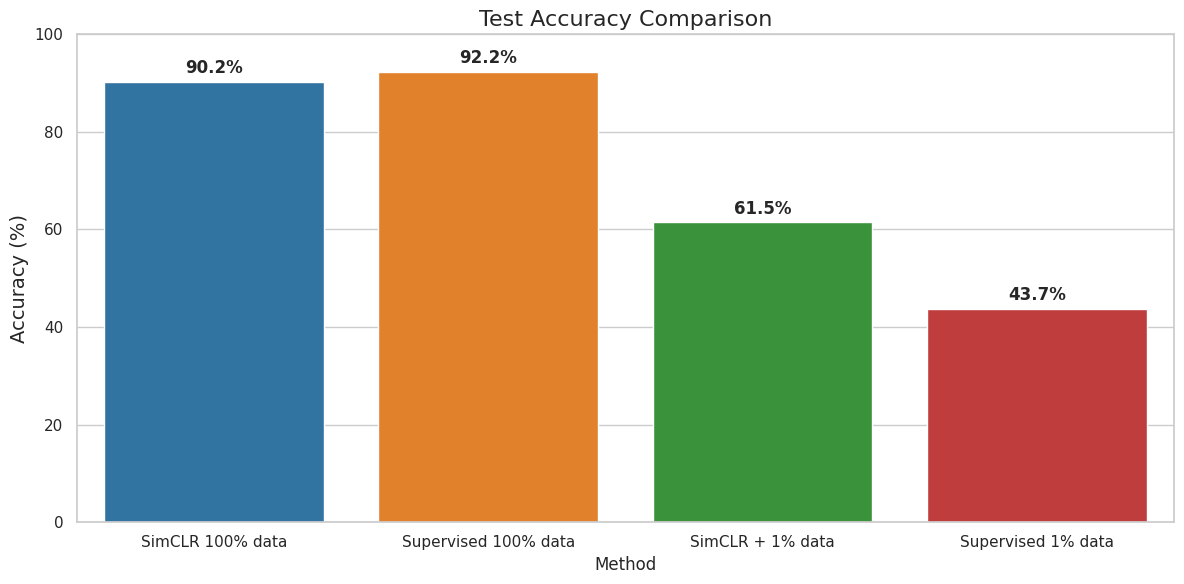

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/

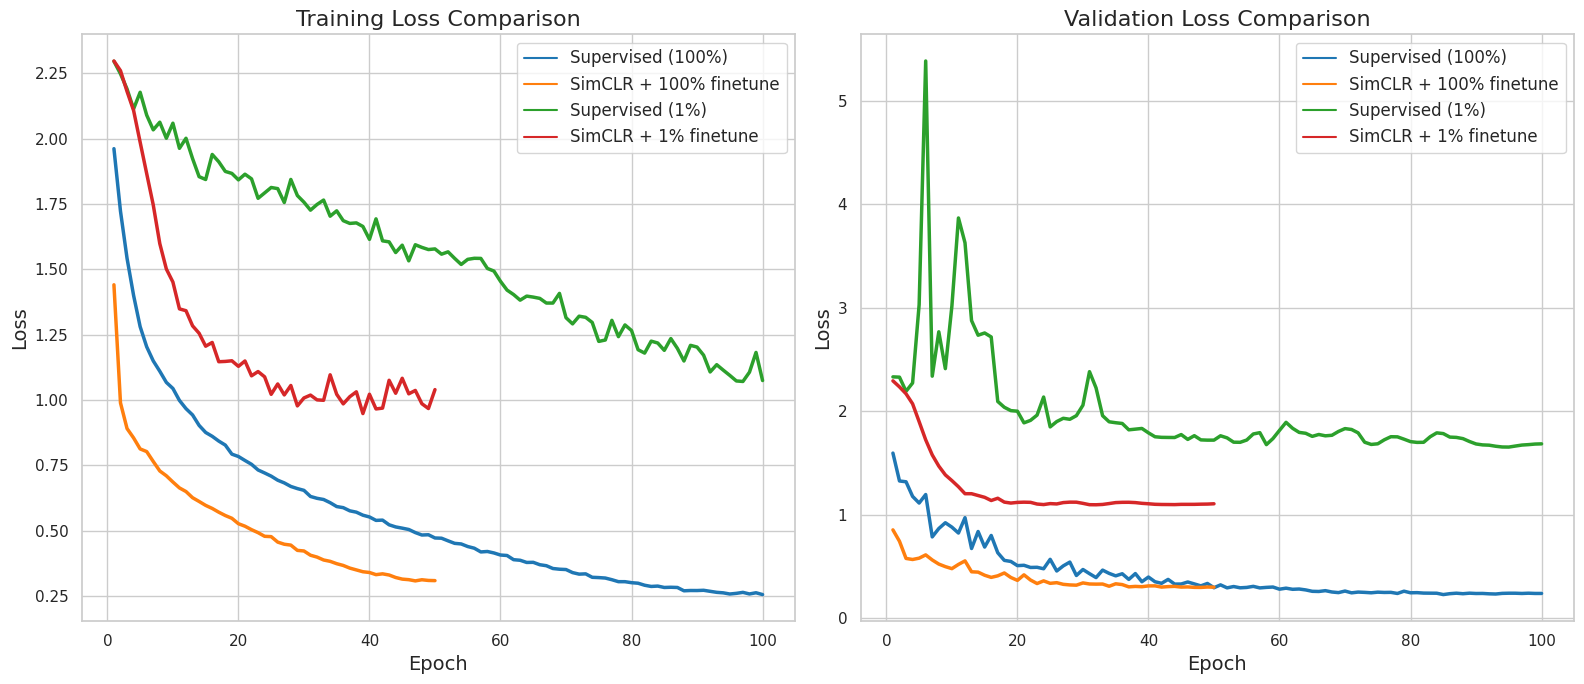

In [77]:
sns.set_theme(style="whitegrid")
plt.rcParams.update({"font.size": 12})

plt.figure(figsize=(12, 6))
methods = ["SimCLR 100% data", "Supervised 100% data", "SimCLR + 1% data", "Supervised 1% data"]
accuracies = [
    finetuned_test_acc,
    supervised_test_acc,
    finetuned_10pct_test_acc,
    supervised_10pct_test_acc,
]

accuracy_df = pd.DataFrame(
    {
        "Method": methods,
        "Accuracy": accuracies,
        "Color": ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"],
    }
)

ax = sns.barplot(
    x="Method", y="Accuracy", data=accuracy_df, palette=accuracy_df["Color"]
)
ax.set_title("Test Accuracy Comparison", fontsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_ylim(0, 100)

for i, bar in enumerate(ax.patches):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{accuracies[i]:.1f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.tight_layout()
plt.savefig("accuracy_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(16, 7))

epochs = range(1, len(supervised_train_losses) + 1)
data = []

for values, name in [
    (supervised_train_losses, "Supervised (100%)"),
    (finetuned_train_losses, "SimCLR + 100% finetune"),
    (supervised_10pct_train_losses, "Supervised (1%)"),
    (finetuned_10pct_train_losses, "SimCLR + 1% finetune"),
]:
    for epoch, value in zip(epochs, values):
        data.append({"Epoch": epoch, "Loss": value, "Method": name, "Type": "Training"})

for values, name in [
    (supervised_val_losses, "Supervised (100%)"),
    (finetuned_val_losses, "SimCLR + 100% finetune"),
    (supervised_10pct_val_losses, "Supervised (1%)"),
    (finetuned_10pct_val_losses, "SimCLR + 1% finetune"),
]:
    for epoch, value in zip(epochs, values):
        data.append(
            {"Epoch": epoch, "Loss": value, "Method": name, "Type": "Validation"}
        )

losses_df = pd.DataFrame(data)

plt.subplot(1, 2, 1)
sns.lineplot(
    data=losses_df[losses_df["Type"] == "Training"],
    x="Epoch",
    y="Loss",
    hue="Method",
    palette="tab10",
    linewidth=2.5,
    markers=True,
    dashes=False,
)
plt.title("Training Loss Comparison", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(title=None, fontsize=12)

plt.subplot(1, 2, 2)
sns.lineplot(
    data=losses_df[losses_df["Type"] == "Validation"],
    x="Epoch",
    y="Loss",
    hue="Method",
    palette="tab10",
    linewidth=2.5,
    markers=True,
    dashes=False,
)
plt.title("Validation Loss Comparison", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(title=None, fontsize=12)

plt.tight_layout()
plt.savefig("loss_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

# Summary

In [78]:
results = {
    "Method": [
        "SimCLR + 100%",
        "Supervised 100%",
        "SimCLR + 1% (frozen)",
        "Supervised 1%",
    ],
    "Test Accuracy": [
        finetuned_test_acc,
        supervised_test_acc,
        finetuned_10pct_test_acc,
        supervised_10pct_test_acc,
    ],
    "Training Epochs": [
        f"{PRETRAINING_EPOCHS} + {FINETUNING_EPOCHS}",
        f"{SUPERVISED_EPOCHS}",
        f"{PRETRAINING_EPOCHS} + {PRETRAINIG_SUBSET_EPOCHS}",
        f"{SUPERVISED_SUBSET_EPOCHS}",
    ],
    "Frozen Encoder": ["No", "No", "Yes", "No"],
    "Trainable Parameters": [
        format(
            sum(
                p.numel() for p in classifier_finetuned.parameters() if p.requires_grad
            ),
            ",",
        ),
        format(
            sum(p.numel() for p in supervised_model.parameters() if p.requires_grad),
            ",",
        ),
        format(
            sum(
                p.numel()
                for p in classifier_finetuned_10pct.parameters()
                if p.requires_grad
            ),
            ",",
        ),
        format(
            sum(
                p.numel()
                for p in classifier_supervised_10pct.parameters()
                if p.requires_grad
            ),
            ",",
        ),
    ],
}

results_df = pd.DataFrame(results)
results_df

,Method,Test Accuracy,Training Epochs,Frozen Encoder,Trainable Parameters
0,SimCLR + 100%,90.22,100 + 50,No,"11,436,618"
1,Supervised 100%,92.22,100,No,"11,436,618"
2,SimCLR + 1% (frozen),61.45,100 + 50,Yes,"267,786"
3,Supervised 1%,43.71,100,No,"11,436,618"


# Embeddings Visualization

In [68]:
def extract_embeddings(model, data_loader, num_samples=1000):
    model.eval()
    embeddings = []
    labels = []
    count = 0

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Extracting embeddings"):
            images = images.to(device)
            batch_embeddings = model.encoder(images).cpu().numpy()
            batch_labels = targets.numpy()

            embeddings.append(batch_embeddings)
            labels.append(batch_labels)

            count += len(images)
            if count >= num_samples:
                break

    embeddings = np.vstack(embeddings)[:num_samples]
    labels = np.concatenate(labels)[:num_samples]

    return embeddings, labels

In [69]:
pretrained_model = create_classifier(pretrained=True, freeze_encoder=True)

num_samples = 5000
embeddings, labels = extract_embeddings(
    pretrained_model, test_loader, num_samples=num_samples
)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Labels shape: {labels.shape}")

Extracting embeddings:  48%|████▊     | 19/40 [00:00<00:01, 19.68it/s]

Embeddings shape: (5000, 512)
Labels shape: (5000,)


In [70]:
umap_obj = umap.UMAP(
        n_components=3,
        n_neighbors=30,
        min_dist=0.1,    
)
embeddings_reduced = umap_obj.fit_transform(embeddings)

In [72]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

df = pd.DataFrame(
    {
        "x": embeddings_reduced[:, 0],
        "y": embeddings_reduced[:, 1],
        "z": embeddings_reduced[:, 2],
        "label": [class_names[l] for l in labels],
    }
)

fig = px.scatter_3d(
    df,
    x="x",
    y="y",
    z="z",
    color="label",
    title=f"3D Visualization of Embeddings using UMAP",
    labels={"label": "Class"},
    color_discrete_sequence=px.colors.qualitative.Plotly,
    opacity=0.8,
)

fig.update_layout(
    scene=dict(
        xaxis=dict(showticklabels=False),
        yaxis=dict(showticklabels=False),
        zaxis=dict(showticklabels=False),
    ),
    legend=dict(itemsizing="constant"),
    margin=dict(r=0, l=0, b=0, t=40),
    height=500,
    width=600
)
fig.show()